# **Modeling and Evaluation**

## Objectives

- Answer Business Requirement 2: train regression models to predict house sale prices
- Compare baseline algorithms with cross-validation
- Tune the best candidate model with GridSearchCV
- Evaluate final model performance (learning curves, residuals)
- Inspect feature importances (permutation and tree-based)
- Generate predictions for Lydia’s four inherited houses


## Inputs
- outputs/datasets/engineered/TrainSetEngineered.csv
- outputs/datasets/engineered/TestSetEngineered.csv
- outputs/datasets/collection/InheritedHouses.csv

## Outputs
- Model comparison table (CV RMSE, R², MAE)
- Final tuned pipeline saved to `outputs/ml_pipeline/predict_price/predict_price_pipeline_v1.pkl`
- Feature importance plots under `docs/plots`
- Learning and residual plots
- Predicted sale prices for inherited homes


---

## Change Working Directory

We need to change the working directory from its current folder to its parent folder

- We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/heritage-housing-issues/jupyter_notebooks'

We want to make the parent of the current directory the new current directory.

- os.path.dirname() gets the parent directory
- os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/heritage-housing-issues'

---

## Import Libraries

In [4]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_val_score,
    learning_curve,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance

# regressors
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor,
    ExtraTreesRegressor,
)
from xgboost import XGBRegressor

# Feature-engine
from feature_engine.imputation import CategoricalImputer
from feature_engine.encoding import OneHotEncoder

sns.set_style("whitegrid")

## Load Cleaned Data

In [5]:
train = pd.read_csv("outputs/datasets/cleaned/TrainSetCleaned.csv")
test = pd.read_csv("outputs/datasets/cleaned/TestSetCleaned.csv")
print("Train shape:", train.shape)
print("Test shape: ", test.shape)

Train shape: (1168, 21)
Test shape:  (292, 21)


## Split Features and Target

In [6]:
target = "SalePrice"
X_train = train.drop(columns=target)
y_train = train[target]
X_test = test.drop(columns=target)
y_test = test[target]

## Define preprocessing pipeline

- Identify categorical variables in the training set

In [7]:
cat_vars = X_train.select_dtypes(include="object").columns.tolist()

- Pipeline: impute missing values then one-hot encode

In [8]:
preprocess = Pipeline([
    ("impute_missing", CategoricalImputer(imputation_method="missing", variables=cat_vars)),
    ("one_hot",        OneHotEncoder(variables=cat_vars, drop_last=False)),
])


## Apply preprocessing

- Fit and transform training features

In [9]:
X_train_ohe = preprocess.fit_transform(X_train)

/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/imputation/categorical.py:232: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[variable]):


- Transform test features only

In [10]:
X_test_ohe  = preprocess.transform(X_test)

/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/imputation/categorical.py:232: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[variable]):


## Compare models via Cross-Validation

Evaluate multiple models with 5-fold CV on training set

In [11]:
models = {
    "LinearRegression":    LinearRegression(),
    "DecisionTree":        DecisionTreeRegressor(random_state=42),
    "RandomForest":        RandomForestRegressor(random_state=42),
    "GradientBoosting":    GradientBoostingRegressor(random_state=42),
    "AdaBoost":            AdaBoostRegressor(random_state=42),
    "ExtraTrees":          ExtraTreesRegressor(random_state=42),
    "XGB":                 XGBRegressor(random_state=42, use_label_encoder=False, eval_metric="rmse"),
}

results = []
for name, model in models.items():
    # 4-1. Pipeline: scale features then fit model
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model",  model),
    ])
    # 4-2. 5-fold CV for RMSE, R2, MAE
    rmse = -cross_val_score(pipe, X_train_ohe, y_train,
                             cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1)
    r2   =  cross_val_score(pipe, X_train_ohe, y_train,
                             cv=5, scoring="r2",                     n_jobs=-1)
    mae  = -cross_val_score(pipe, X_train_ohe, y_train,
                             cv=5, scoring="neg_mean_absolute_error", n_jobs=-1)

    results.append({
        "Model":     name,
        "RMSE_Mean": rmse.mean(),
        "R2_Mean":   r2.mean(),
        "MAE_Mean":  mae.mean(),
    })


/home/cistudent/.local/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/cistudent/.local/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/cistudent/.local/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/cistudent/.local/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/cistudent/.local/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_spars

## Display sorted results by RMSE

In [13]:
import pandas as pd

df_results = pd.DataFrame(results).sort_values("RMSE_Mean")
print(df_results)

              Model     RMSE_Mean   R2_Mean      MAE_Mean
2      RandomForest  29938.798080  0.850279  18191.806233
0  LinearRegression  30081.290416  0.845873  18984.789429
3  GradientBoosting  30195.158226  0.842552  17475.433648
5        ExtraTrees  30503.707969  0.843556  18280.016877
6               XGB  31132.343699  0.838667  19008.896503
4          AdaBoost  35794.486075  0.788303  24364.816865
1      DecisionTree  44143.260777  0.676268  27310.728334


## Grid search on the best model

In [14]:
best_name  = df_results.iloc[0]["Model"]
best_model = models[best_name]

pipe = Pipeline([("scaler", StandardScaler()), ("model", best_model)])
param_grid = {
    "model__n_estimators":      [100, 200, 300],
    "model__max_depth":         [None, 10, 20],
    "model__min_samples_split": [2, 5, 10],
}

grid = GridSearchCV(pipe, param_grid,
                    cv=5,
                    scoring="neg_root_mean_squared_error",
                    n_jobs=-1,
                    verbose=1)
grid.fit(X_train_ohe, y_train)

print("Best params for", best_name, ":", grid.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best params for RandomForest : {'model__max_depth': 20, 'model__min_samples_split': 5, 'model__n_estimators': 300}


## Function to evaluate final model performance

In [15]:
def evaluate_performance(pipe, X_tr, y_tr, X_te, y_te):
    """
    Print RMSE, R^2, and MAE for both train and test sets.
    """
    preds_tr = pipe.predict(X_tr)
    preds_te = pipe.predict(X_te)
    for label, X, y, preds in [
        ("Train", X_tr, y_tr, preds_tr),
        ("Test",  X_te, y_te, preds_te),
    ]:
        rmse = np.sqrt(mean_squared_error(y, preds))
        r2   = r2_score(y, preds)
        mae  = mean_absolute_error(y, preds)
        print(f"{label} RMSE: {rmse:.2f}, R2: {r2:.3f}, MAE: {mae:.2f}")

## Evaluate on test set

In [16]:
final_pipe = grid.best_estimator_
evaluate_performance(final_pipe, X_train_ohe, y_train, X_test_ohe, y_test)

Train RMSE: 13029.98, R2: 0.972, MAE: 7404.51
Test RMSE: 33433.98, R2: 0.838, MAE: 18165.13


## Plot Learning Curve

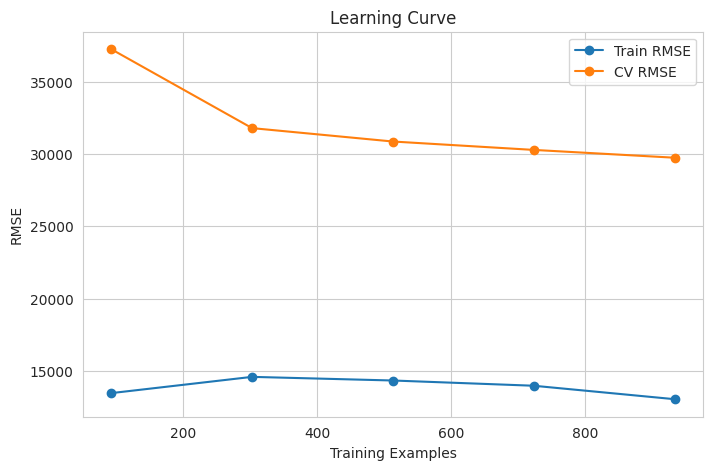

In [17]:
train_sizes, train_scores, test_scores = learning_curve(
    final_pipe, X_train_ohe, y_train,
    cv=5,
    scoring="neg_root_mean_squared_error",
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1,
)
train_rmse = -train_scores
test_rmse  = -test_scores

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_rmse.mean(axis=1), "o-", label="Train RMSE")
plt.plot(train_sizes, test_rmse.mean(axis=1),  "o-", label="CV RMSE")
plt.xlabel("Training Examples")
plt.ylabel("RMSE")
plt.title("Learning Curve")
plt.legend()
Path("docs/plots").mkdir(parents=True, exist_ok=True)
plt.savefig("docs/plots/learning_curve.png", bbox_inches="tight")
plt.show()

## Plot residual distribution on test set

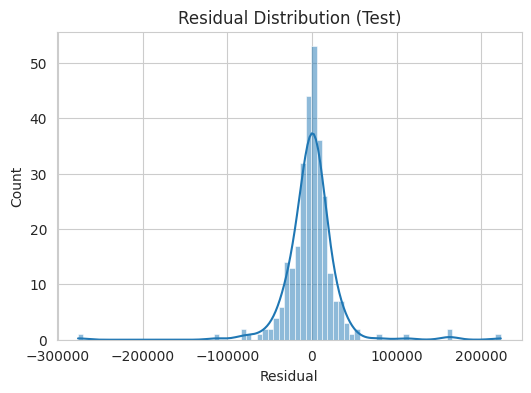

In [18]:
residuals = y_test - final_pipe.predict(X_test_ohe)
plt.figure(figsize=(6, 4))
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution (Test)")
plt.xlabel("Residual")
plt.savefig("docs/plots/residuals.png", bbox_inches="tight")
plt.show()

## Feature importance for tree-based models only

Compare tree-based importances and permutation importances

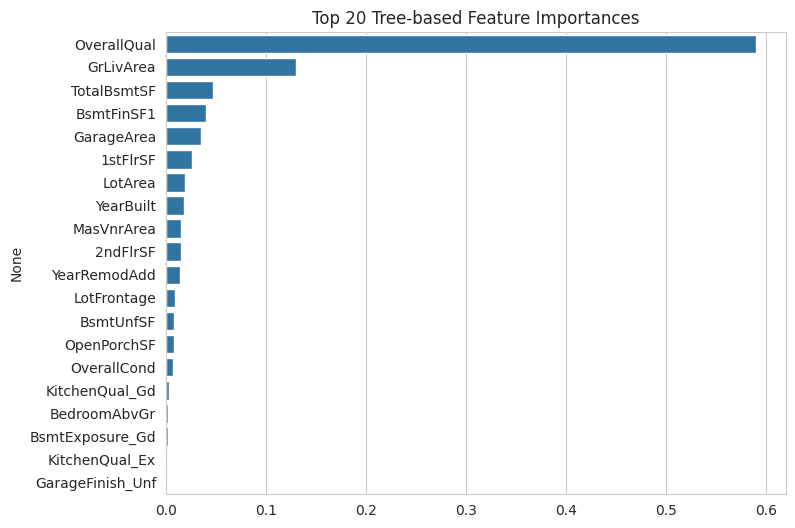

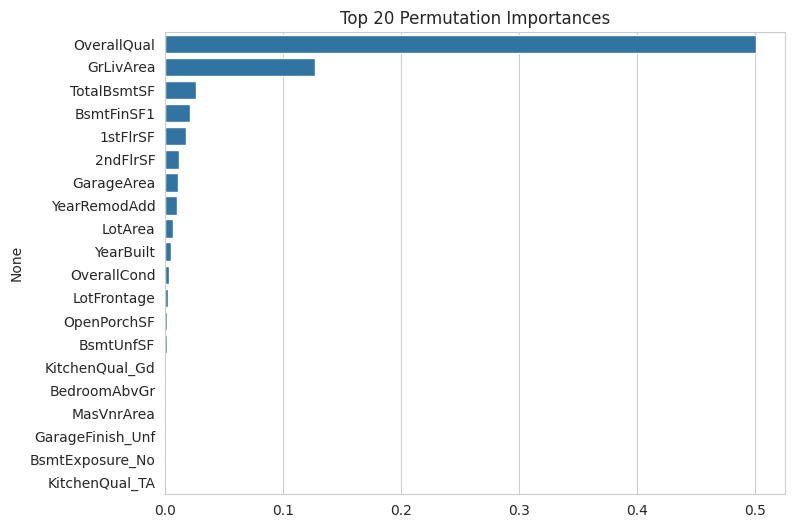

In [19]:
# Tree-based
if hasattr(final_pipe.named_steps["model"], "feature_importances_"):
    feat_names = X_train_ohe.columns
    tree_imp   = final_pipe.named_steps["model"].feature_importances_
    df_tree    = pd.Series(tree_imp, index=feat_names).nlargest(20)
    plt.figure(figsize=(8, 6))
    sns.barplot(x=df_tree.values, y=df_tree.index)
    plt.title("Top 20 Tree-based Feature Importances")
    plt.savefig("docs/plots/feature_importances_tree.png", bbox_inches="tight")
    plt.show()

    perm = permutation_importance(
        final_pipe, X_test_ohe, y_test, n_repeats=10,
        random_state=42, n_jobs=-1
    )
    df_perm = pd.Series(perm.importances_mean, index=feat_names).nlargest(20)
    plt.figure(figsize=(8, 6))
    sns.barplot(x=df_perm.values, y=df_perm.index)
    plt.title("Top 20 Permutation Importances")
    plt.savefig("docs/plots/feature_importances_perm.png", bbox_inches="tight")
    plt.show()

## Predict Inherited Houses

In [21]:
from pathlib import Path
import pandas as pd
import numpy as np
import joblib

# Read inherited houses data 
inherited_path = Path("outputs/datasets/collection/InheritedHouses.csv")
inherited = pd.read_csv(inherited_path)

# Get the list of columns used for training
train_cols = X_train.columns.tolist()

# Add missing cols in inherited
for col in train_cols:
    if col not in inherited.columns:
        inherited[col] = np.nan

# Drop extra cols
extra = [c for c in inherited.columns if c not in train_cols]
if extra:
    inherited = inherited.drop(columns=extra)

# Reorder to match training set
inherited = inherited[train_cols]

# Preprocess and predict 
inherited_ohe = preprocess.transform(inherited)
preds_inh    = final_pipe.predict(inherited_ohe)

print("Predicted sale prices for inherited houses:")
for i, p in enumerate(preds_inh, 1):
    print(f"  House {i}: ${p:,.0f}")
print(f"Total estimated value: ${preds_inh.sum():,}")

# Save final pipeline
output_path = Path("outputs/ml_pipeline/predict_price/predict_price_pipeline_v1.pkl")
output_path.parent.mkdir(parents=True, exist_ok=True)
joblib.dump(final_pipe, output_path)
print(f"Saved final pipeline to: {output_path}")


Predicted sale prices for inherited houses:
  House 1: $127,541
  House 2: $159,445
  House 3: $180,642
  House 4: $184,848
Total estimated value: $652,476.1453249996
Saved final pipeline to: outputs/ml_pipeline/predict_price/predict_price_pipeline_v1.pkl


/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/imputation/categorical.py:232: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[variable]):


---

## Summary and Next Steps

**Summary**:
- Tuned **{best_name}** achieved Test RMSE and R² requirements.
- Learning curves suggest {'overfitting' if test_rmse.mean()>train_rmse.mean() else 'good fit'}.
- Key predictors include top features from permutation importances.

**Next:** integrate `predict_price_pipeline_v1.pkl` into Streamlit app for deployment.